In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices, load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

In [2]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

In [3]:
fname = "2020_9_30.hdf"
dset_name = "1601498736 shutter rotational cooling  laser"
title = "shutter rotational cooling laser"

dset_names = [dset_name]
devices = ('Laser Lock', 'Wavelength', 'ZaberTMM')

In [4]:
pmt_channel = 1
pxie, pxie_time, data_devices = load_measurement_data_devices(fname, dset_name, devices)
pxie_data = [dat[:,pmt_channel] for dat in pxie.values()]

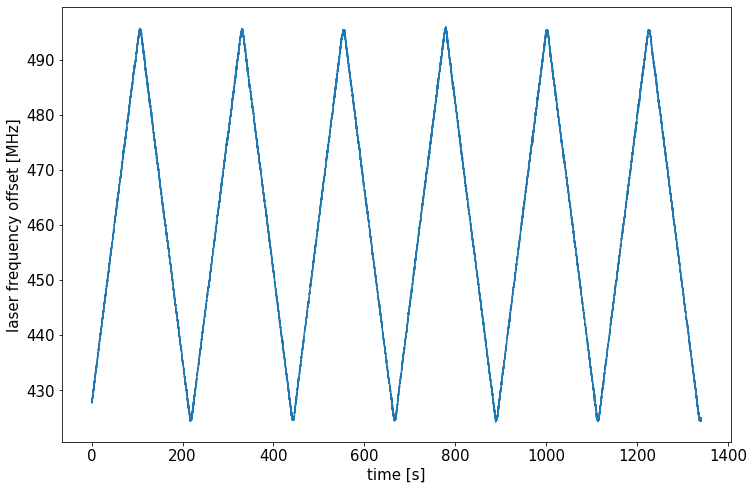

In [5]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(data_devices['Laser Lock']['time'],
        data_devices['Laser Lock']['laser 1 frequency'])

ax.set_xlabel('time [s]')
ax.set_ylabel('laser frequency offset [MHz]')
set_fontsize(ax, 15)

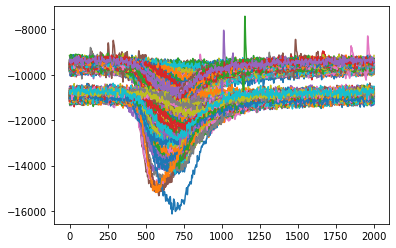

In [6]:
data = np.array(pxie_data[:500])

plt.plot(data.T);

In [7]:
idx_pairs = {idx_pxie: find_nearest_idx(data_devices['Laser Lock']['time'], t_pxie) for idx_pxie, t_pxie in pxie_time.items()}
sorted_pxie_indices = np.array(list(idx_pairs.keys()))
sorted_pxie_indices.sort()

In [8]:
ch = 1
integrals_unsorted = [-np.trapz(pxie[idx][250:2000, ch]-np.mean(pxie[idx][0:200, ch])) for idx in range(1, max(pxie_time.keys())+1)]

In [9]:
sorted_pxie_indices = np.array(list(idx_pairs.keys()))

In [10]:
sorted_pxie_indices = np.array(list(idx_pairs.keys()))
sorted_pxie_indices.sort()
integrals, freqs = combine_arrays_irregular(sorted_pxie_indices-1, integrals_unsorted, 
                                            [idx_pairs[idx] for idx in sorted_pxie_indices], data_devices['Laser Lock']['laser 1 frequency'])
integrals, freqs = np.array(integrals), np.array(freqs)

In [11]:
ch = 1

mask_open = []
mask_closed = []
for idx in sorted_pxie_indices:
    m = np.mean(pxie[idx][:,ch][0:250]) 
    if m > -10500:
        mask_closed.append(idx)
    elif m < -10500:
        mask_open.append(idx)
mask_open = np.array(mask_open)
mask_closed = np.array(mask_closed)

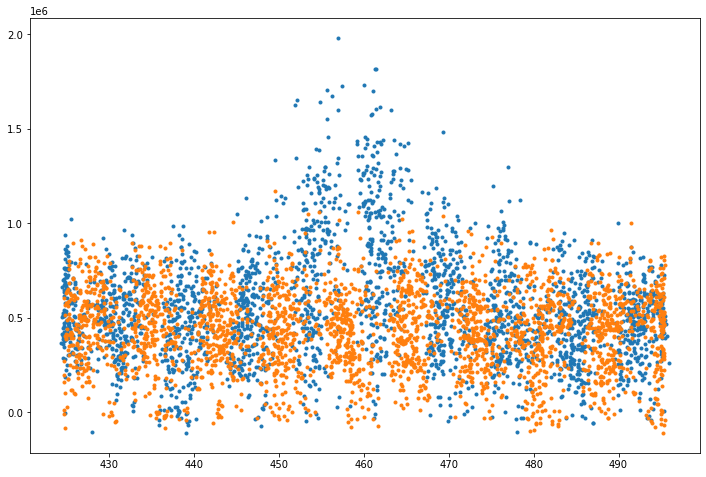

In [12]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(freqs[mask_open-1], integrals[mask_open-1], '.')
ax.plot(freqs[mask_closed-1], integrals[mask_closed-1], '.')

In [13]:
def filter_integrals(binned_data, minimum):
    filtered_data = {}
    for b, data in binned_data.items():
        filtered_data[b] = [d for d in data if d > minimum]
    return filtered_data

In [14]:
mo = mask_open - 1
mc = mask_closed -1
bins_mo, bin_data_mo = bin_data(freqs[mo], integrals[mo], width = 1)
bins_mc, bin_data_mc = bin_data(freqs[mc], integrals[mc], width = 1)

bin_data_mo = filter_integrals(bin_data_mo, 0.1e6)
bin_data_mc = filter_integrals(bin_data_mc, 0.1e6)

In [15]:
bin_data_mo_avg = average_binned_data(bins_mo, bin_data_mo)
bin_data_mc_avg = average_binned_data(bins_mc, bin_data_mc)

<BarContainer object of 73 artists>

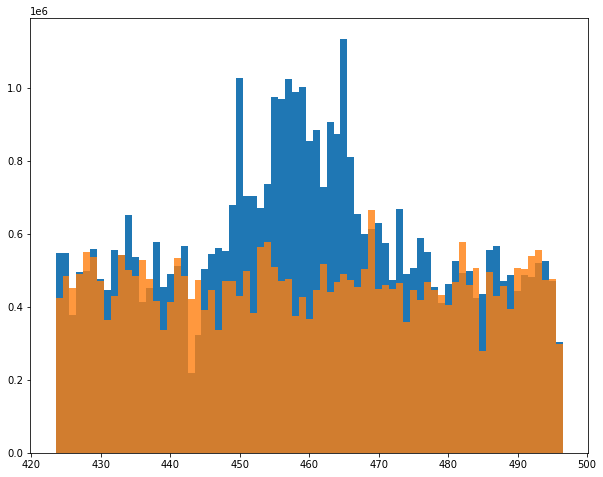

In [16]:
fig, ax = plt.subplots(figsize = (10,8))
ax.bar(bins_mo, [bin_data_mo_avg[b][0] for b in bin_data_mo], width = 1)
ax.bar(bins_mc, [bin_data_mc_avg[b][0] for b in bin_data_mc], width = 1, alpha = 0.8)

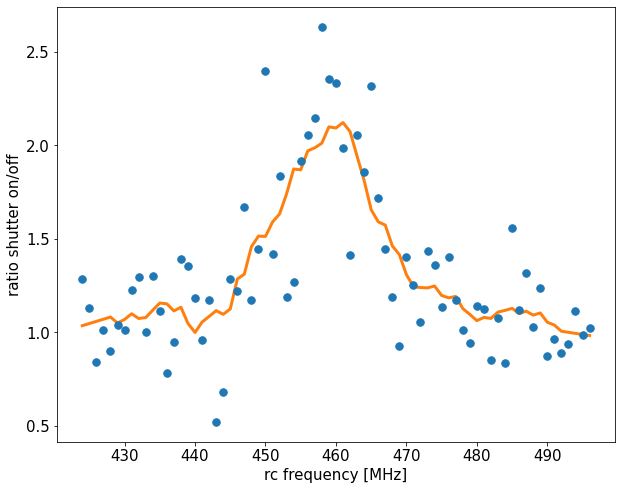

In [17]:
from scipy.signal import savgol_filter

y = np.array([val[0] for val in bin_data_mo_avg.values()])/np.array([val[0] for val in bin_data_mc_avg.values()])
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(bins_mo, y, '.', ms = 15)
ax.plot(bins_mo, savgol_filter(y, 9, 1), lw = 3, zorder = 0)

ax.set_xlabel('rc frequency [MHz]')
ax.set_ylabel('ratio shutter on/off')
set_fontsize(ax, 15)

In [18]:
print(f'{y[:20].mean():.3f} +/- {y[:20].std()/np.sqrt(20):.3f}')
print(f'{y[-20:].mean():.3f} +/- {y[-20:].std()/np.sqrt(20):.3f}')

1.073 +/- 0.047
1.061 +/- 0.038


In [19]:
data = []
ch = 1

for idx_pxie, idx_laserlock in idx_pairs.items():
    f = data_devices['Laser Lock']['laser 1 frequency'][idx_laserlock]
    if f < 430:
        data.append(pxie[idx_pxie][:,ch])
    elif f > 490:
        data.append(pxie[idx_pxie][:,ch])
data = np.array(data)

In [20]:
mo2, mc2 = [], []
for idx, d in enumerate(data):
    m = np.mean(d[0:250]) 
    if m > -10500:
        mc2.append(idx)
    elif m < -10500:
        mo2.append(idx)
mo2 = np.array(mo2)
mc2 = np.array(mc2)

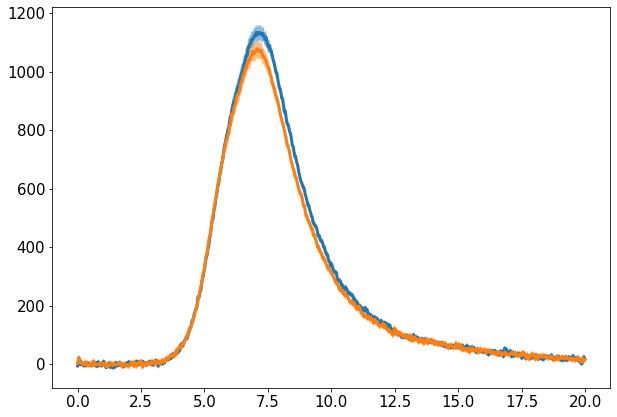

In [21]:
yo = np.mean(data[mo2], axis = 0)
yc = np.mean(data[mc2], axis = 0)
yo -= np.mean(yo[:250])
yc -= np.mean(yc[:250])

syo = np.std(data[mo2], axis = 0)
syo /= np.sqrt(len(mo2))
syc = np.std(data[mc2], axis = 0)
syc /= np.sqrt(len(mc2))


x = np.linspace(0,1999,2000)/100

fig, ax = plt.subplots(figsize = (10,7))
ax.plot(x, -yo, lw = 3)
ax.plot(x, -yc, lw = 3)
ax.fill_between(x, -yo-syo, -yo+syo, alpha = 0.5)
ax.fill_between(x, -yc-syc, -yc+syc, alpha = 0.5)

set_fontsize(ax, 15)

In [22]:
np.trapz(-yo)/np.trapz(-yc)

1.0551996187586057

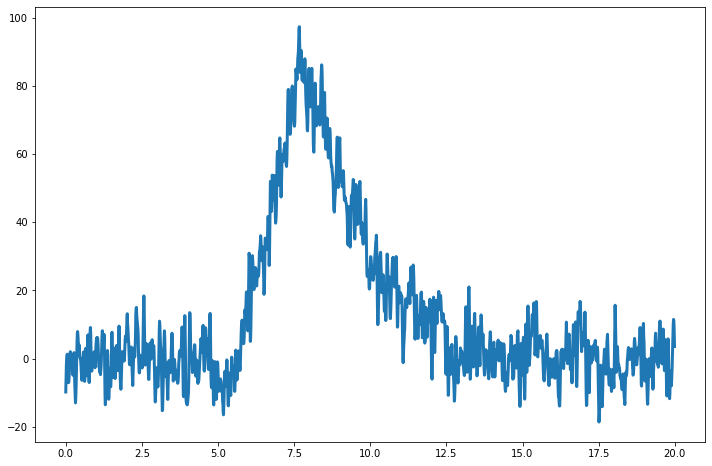

In [23]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x, -yo+yc, lw = 3)

# Power Scan Rotational Cooling
R0 F1 detection  
P2 F1 rotational cooling

| amplifier current [A] | 5 | 5.25 | 5.5 | 5.75 | 6 | 6.25 | 6.5 |  
|-----|-----|-----|-----|-----|-----|-----|-----|  
| laser power [mW] | 19.5 | 24.5 | 29.5 | 34.5 | 38 | 42.5 | 44 |  


In [24]:
fname = "2020_9_30.hdf"
dset_name = '1601509056 rotational cooling scan power'

dset_names = [dset_name]
devices = ('Laser Lock', 'Wavelength', 'ZaberTMM')

In [25]:
powers_mW = [19.5,24.5, 29.5, 34.5, 38, 42.5, 44]

In [26]:
pmt_channel = 1
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [27]:
qswitch_fired = []
qswitch_not_fired = []
for key, val in pxie.items():
    if np.max(val[:,0]) > 500:
        qswitch_fired.append(key)
    else:
        qswitch_not_fired.append(key)
qswitch_fired.sort()
qswitch_not_fired.sort()

In [28]:
ch = 1
powers = np.linspace(5,6.5,7)
indices_grouped = {p: {'open': [], 'closed': []} for p in powers}
data_grouped = {p: {'open': [], 'closed': []} for p in powers}

for idx in qswitch_fired:
    attrs = pxie_attrs[idx]
    p = attrs['Seed1Amplifier SetCurrent']
    if attrs['ShutterControl SetVoltage'] == '0':
        indices_grouped[p]['closed'].append(idx)
        data_grouped[p]['closed'].append(pxie[idx][:,ch])
    elif attrs['ShutterControl SetVoltage'] == '5':
        indices_grouped[p]['open'].append(idx)
        data_grouped[p]['open'].append(pxie[idx][:,ch])

5.0 A -> integral ratio : 1.72636 +/- 0.10376
5.2 A -> integral ratio : 1.80262 +/- 0.08870
5.5 A -> integral ratio : 1.82862 +/- 0.10828
5.8 A -> integral ratio : 1.84954 +/- 0.06014
6.0 A -> integral ratio : 1.89252 +/- 0.07803
6.2 A -> integral ratio : 1.91261 +/- 0.07033
6.5 A -> integral ratio : 1.98972 +/- 0.08329


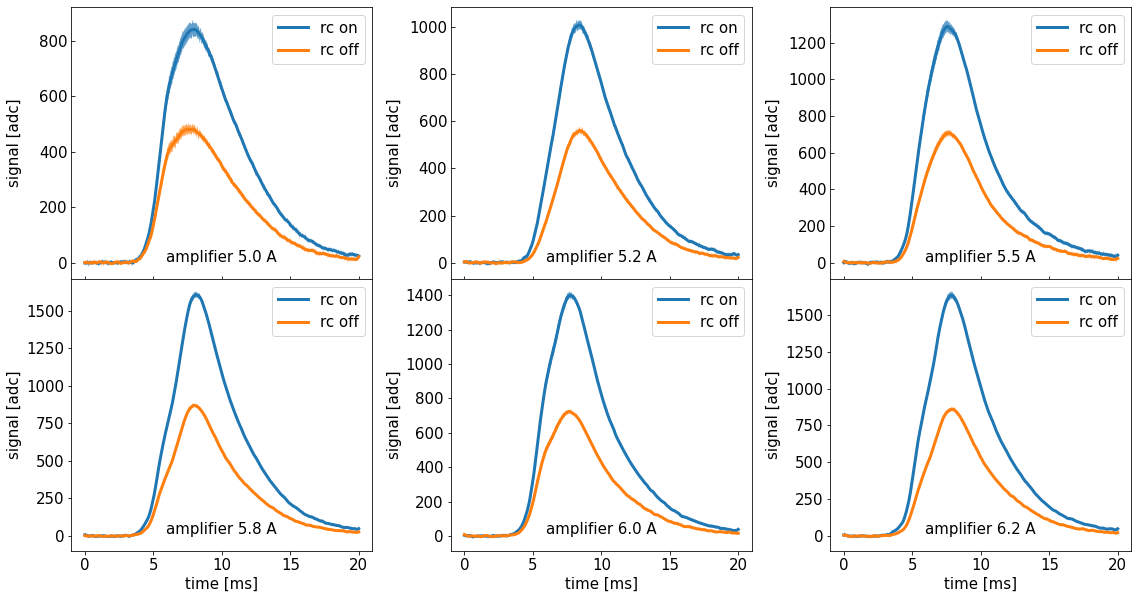

In [29]:
from scipy.signal import savgol_filter

figf, axf = plt.subplots(2,3,figsize = (19,10), sharex = True, 
            gridspec_kw={'hspace': 0, 'wspace': .26, 'height_ratios': [1,1]})

axp = {p:ax for p,ax in zip(powers, axf.flatten())}

ratios = []

for p in powers:
    yo = np.mean(data_grouped[p]['open'], axis = 0)
    yc = np.mean(data_grouped[p]['closed'], axis = 0)
    yo -= np.mean(yo[:300])
    yc -= np.mean(yc[:300])

    lo = len(data_grouped[p]['open'])
    lc = len(data_grouped[p]['closed'])

    syo = np.std(data_grouped[p]['open'], axis = 0)
    syo /= np.sqrt(lo)
    syc = np.std(data_grouped[p]['closed'], axis = 0)
    syc /= np.sqrt(lc)

    x = np.linspace(0,1999,2000)/100
    
    trapzo = np.trapz(-yo)
    trapzc = np.trapz(-yc)
    trapz_error = (trapzo/trapzc)*np.sqrt((np.sum(syo)/trapzo)**2 + (np.sum(syc)/trapzc)**2)
    print(f'{p:.1f} A -> integral ratio : {np.trapz(-yo)/np.trapz(-yc):.5f} +/- {trapz_error:.5f}')
    
    ratios.append((trapzo/trapzc,trapz_error))
    
    if p in axp:
        axp[p].fill_between(x, -yo-syo, -yo+syo, alpha = .7)
        axp[p].fill_between(x, -yc-syc, -yc+syc, alpha = .7)
        axp[p].plot(x, -savgol_filter(yo, 51, 3), lw = 3, label= 'rc on')
        axp[p].plot(x, -savgol_filter(yc, 51, 3), lw = 3, label = 'rc off')
        axp[p].set_xlabel('time [ms]')
        axp[p].set_ylabel('signal [adc]')
        axp[p].text(0.5, 0.05, f'amplifier {p:.1f} A', transform=axp[p].transAxes, fontsize = 15,
                   ha = 'center', va = 'bottom')
        
        axp[p].legend(fontsize = 15)
        set_fontsize(axp[p], 15)

for ax in list(axp.values())[:len(axp)//2]:
    ax.tick_params(direction = 'in')

figf.align_labels()

# figf.savefig(f'rc_cooling.png', dpi = 300, bbox_inches='tight')

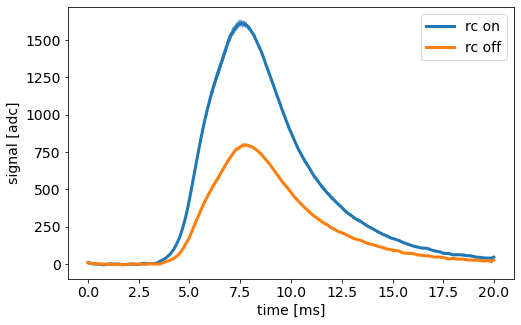

In [34]:
p = 6.5
yo = np.mean(data_grouped[p]['open'], axis = 0)
yc = np.mean(data_grouped[p]['closed'], axis = 0)
yo -= np.mean(yo[:300])
yc -= np.mean(yc[:300])

lo = len(data_grouped[p]['open'])
lc = len(data_grouped[p]['closed'])

syo = np.std(data_grouped[p]['open'], axis = 0)
syo /= np.sqrt(lo)
syc = np.std(data_grouped[p]['closed'], axis = 0)
syc /= np.sqrt(lc)

x = np.linspace(0,1999,2000)/100
    
fig, ax = plt.subplots(figsize = (8,5))

ax.fill_between(x, -yo-syo, -yo+syo, alpha = .7)
ax.fill_between(x, -yc-syc, -yc+syc, alpha = .7)
ax.plot(x, -savgol_filter(yo, 51, 3), lw = 3, label= 'rc on')
ax.plot(x, -savgol_filter(yc, 51, 3), lw = 3, label = 'rc off')
ax.set_xlabel('time [ms]')
ax.set_ylabel('signal [adc]')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)
fig.savefig('rc_signal.png', dpi = 300)

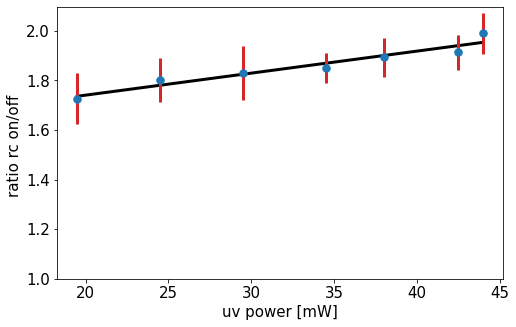

In [30]:
y, yerr = zip(*ratios)
fig, ax = plt.subplots(figsize = (8,5))

ax.errorbar(powers_mW, y, yerr, fmt = '.', ecolor = 'C3', lw = 3, ms = 15)

f = np.polyfit(powers_mW, y, 1)

ax.plot(powers_mW, np.poly1d(f)(powers_mW), lw = 3, color = 'k', zorder = 0)
ax.set_ylim(ymin = 1)
ax.set_xlabel('uv power [mW]')
ax.set_ylabel('ratio rc on/off ')

set_fontsize(ax, 15)

In [31]:
trapz_error

0.08328742809747429